In [1]:
pwd

'g:\\Shared drives\\code\\projects\\pcmo\\notebooks'

# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import xarray as xr
import sys
from tqdm.notebook import tqdm
from time import time
from glob import glob
from os.path import exists, basename
import h5py

# load data

In [4]:
file = r'../data/4-4-2024/220k_1.h5'
roi = np.s_[150:1000, 1100:1900]
with h5py.File(file, 'r') as f:
    img = f['entry']['data']['data'][(0, *roi)]

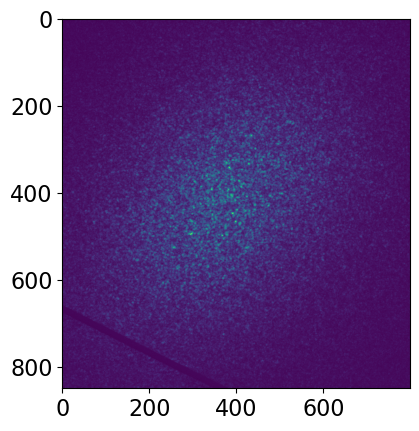

In [5]:
plt.figure()
plt.imshow(img)
plt.show()

In [6]:
with h5py.File(file, 'r') as f:
    data = f['entry']['data']['data'][(..., *roi)]

In [15]:
data.shape

(2222, 850, 800)

In [24]:
from numba import cuda, float32
import numpy as np
import math
from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit
import dask.array as da

# Initialize CUDA Driver API
(err,) = cuInit(0)

# Get attributes
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

@cuda.jit
def nb_cuda_g2(img_stack, g2):
    tau, row, col = cuda.grid(3)
    # print(tau, row, col)
    if tau < g2.shape[0] and row < g2.shape[1] and col < g2.shape[2]:
        d = img_stack.shape[0]
        for t in range(d - tau):
            g2[tau, row, col] += img_stack[t, row, col] * img_stack[t + tau, row, col]
        t_sum = 0
        for t in range(d):
            t_sum += img_stack[t, row, col]
        g2[tau, row, col] = g2[tau, row, col] / (d - tau) / (t_sum / d)**2

# TODO: if data size exceeds gpu memory limits add outer function to split data and perform multiple cuda calls

def host_nb_cuda_g2(img_stack, threadsperblock=(MAX_THREADS_PER_BLOCK//10//10, 10, 10)):
    if not img_stack.size:
        return
    g2 = np.zeros_like(img_stack)
    blockspergrid = tuple(map(int, np.ceil(img_stack.shape/np.array(threadsperblock))))
    dev_data = cuda.to_device(np.ascontiguousarray(img_stack))
    dev_g2 = cuda.to_device(g2)
    print('Blocks in grid:', blockspergrid)
    print('Threads per block:', threadsperblock)
    nb_cuda_g2[blockspergrid, threadsperblock](dev_data, dev_g2)
    g2 = dev_g2.copy_to_host()
    return g2


def dask_nb_cuda_g2(img_stack, threadsperblock=(MAX_THREADS_PER_BLOCK//10//10, 10, 10), xy_chunks=None):
    if xy_chunks is None:
      block_size = int((MAX_GRID_DIM_X/img_stack.shape[0])**.5)   # NOTE: time dimension must be less than max block size here
      xy_chunks = (block_size, block_size)

    dask_imgs = da.from_array(img_stack, chunks=(-1, *xy_chunks))
    print('Dask chunks/cuda grids:', dask_imgs.blocks.shape)

    g2 = dask_imgs.map_blocks(host_nb_cuda_g2, dtype=np.single, threadsperblock=threadsperblock)
    return g2.compute()

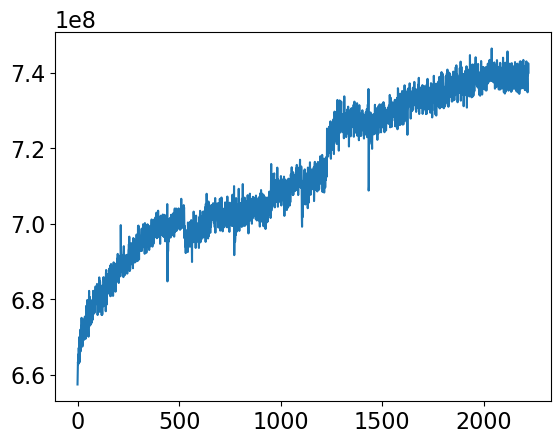

In [13]:
intensity = data.sum(axis=(1,2))
plt.figure()
plt.plot(intensity)
plt.show()

# calculate g2

In [36]:
%%time
# Host code
g2 = dask_nb_cuda_g2(data.astype('float'))

Dask chunks/cuda grids: (1, 1, 1)
Blocks in grid: (223, 85, 80)
Threads per block: (10, 10, 10)
CPU times: total: 3min 44s
Wall time: 3min 47s


In [38]:
g2.shape

(2222, 850, 800)

In [37]:
g2[0]

array([[1.00252704, 1.00233915, 1.00282036, ..., 1.00458246, 1.00533544,
        1.00645038],
       [1.00277765, 1.00280811, 1.00337943, ..., 1.00365173, 1.00409523,
        1.00475526],
       [1.00260524, 1.00289856, 1.00335142, ..., 1.00307636, 1.00312185,
        1.00365837],
       ...,
       [1.00358914, 1.00355604, 1.00339189, ..., 1.00337072, 1.00270826,
        1.00217293],
       [1.00416738, 1.00312825, 1.00280482, ..., 1.00292907, 1.00237518,
        1.00252891],
       [1.00456746, 1.00370323, 1.00302785, ..., 1.00238705, 1.00231797,
        1.00248144]])

In [39]:
temp = 225
ds = xr.Dataset(
        data_vars={'g2_stack': (('g2', 'row', 'col'), g2)},
        coords={
            'lags': np.arange(g2.shape[0]),
            'row': np.arange(g2.shape[1]),
            'col': np.arange(g2.shape[2]),
        },
        attrs=dict(temperature=temp)
)

In [40]:
ds

<xarray.Dataset>
Dimensions:   (g2: 2222, row: 850, col: 800, lags: 2222)
Coordinates:
  * lags      (lags) int32 0 1 2 3 4 5 6 ... 2215 2216 2217 2218 2219 2220 2221
  * row       (row) int32 0 1 2 3 4 5 6 7 8 ... 842 843 844 845 846 847 848 849
  * col       (col) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
Dimensions without coordinates: g2
Data variables:
    g2_stack  (g2, row, col) float64 1.003 1.002 1.003 ... 0.9503 1.02 1.035
Attributes:
    temperature:  225

In [41]:
out_file = f'../data/{temp}K_g2.h5'
ds.to_netcdf(out_file, engine='h5netcdf')

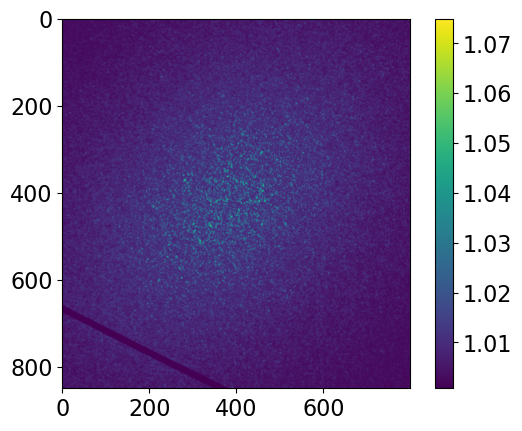

In [42]:
plt.imshow(g2[0])
plt.colorbar()
plt.show()

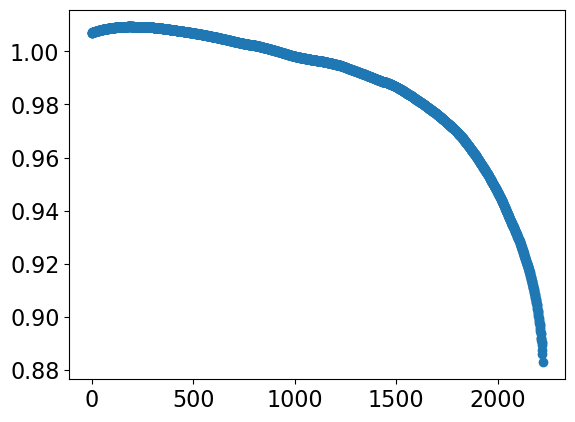

In [49]:
plt.plot(g2[1:,300:500, 300:500].mean(axis=(1,2)), '-o')
#plt.semilogx()

# loop

In [25]:
files = sorted(glob('../data/*_1*'))
files

['../data\\220k_1.h5', '../data\\225k_1.h5', '../data\\230k_1.h5']

In [40]:
ds_g2 = xr.Dataset(
    data_vars={'g2_stack': (('g2', 'row', 'col'), g2_dask_nb_cuda)},
    coords={
        'lags': np.arange(g2_dask_nb_cuda.shape[0]),
        'row': np.arange(g2_dask_nb_cuda.shape[1]),
        'col': np.arange(g2_dask_nb_cuda.shape[2]),
    },
    attrs=dict(temperature=temp)
    )
ds_g2.to_netcdf(out_file, engine='h5netcdf')

In [27]:
for file in tqdm(files):
    temp = int(basename(file)[:3])  
    out_file = f'../data/{temp}K_g2_intensity_norm.h5'
    if exists(out_file):
        continue
    
    roi = np.s_[150:1000, 1100:1900]
    with h5py.File(file, 'r') as f:
        imgs = f['entry']['data']['data'][(..., *roi)]

    intensity = imgs.sum(axis=(1,2))
    imgs = imgs.astype(float) / np.expand_dims(intensity, axis=(1,2))
    g2_dask_nb_cuda = dask_nb_cuda_g2(imgs)
    
    ds_g2 = xr.Dataset(
        data_vars={'g2_stack': (('g2', 'row', 'col'), g2_dask_nb_cuda)},
        coords={
            'lags': np.arange(g2_dask_nb_cuda.shape[0]),
            'row': np.arange(g2_dask_nb_cuda.shape[1]),
            'col': np.arange(g2_dask_nb_cuda.shape[2]),
        },
        attrs=dict(temperature=temp)
        )
    ds_g2.to_netcdf(out_file, engine='h5netcdf')

  0%|          | 0/3 [00:00<?, ?it/s]

Dask chunks/cuda grids: (1, 1, 1)
Blocks in grid: (223, 85, 80)
Threads per block: (10, 10, 10)
Dask chunks/cuda grids: (1, 1, 1)
Blocks in grid: (223, 85, 80)
Threads per block: (10, 10, 10)
Dask chunks/cuda grids: (1, 1, 1)
Blocks in grid: (223, 85, 80)
Threads per block: (10, 10, 10)


## end loop

In [2]:
file = '../data/220K_g2.h5'
ds = xr.open_dataset(file,)
g2 = ds['g2_stack'][0].compute()

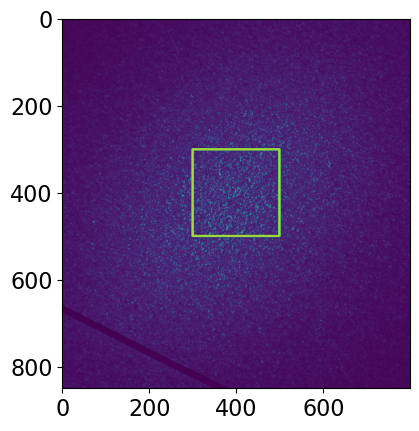

In [6]:
roi = np.s_[300:500, 300:500]
overlay = np.zeros_like(g2)
overlay[roi] = 1

plt.imshow(g2)
plt.contour(overlay)

In [28]:
file = '../data/220K_g2_intensity_norm.h5'
ds = xr.open_dataset(file,)
g220 = ds['g2_stack'][(..., *roi)].mean(axis=(1,2)).compute()

file = '../data/225K_g2_intensity_norm.h5'
ds = xr.open_dataset(file,)
g225 = ds['g2_stack'][(..., *roi)].mean(axis=(1,2)).compute()

file = '../data/230K_g2_intensity_norm.h5'
ds = xr.open_dataset(file,)
g230 = ds['g2_stack'][(..., *roi)].mean(axis=(1,2)).compute()

In [38]:
g230

<xarray.DataArray 'g2_stack' (g2: 2222)>
array([nan, nan, nan, ..., nan, nan, nan])
Dimensions without coordinates: g2

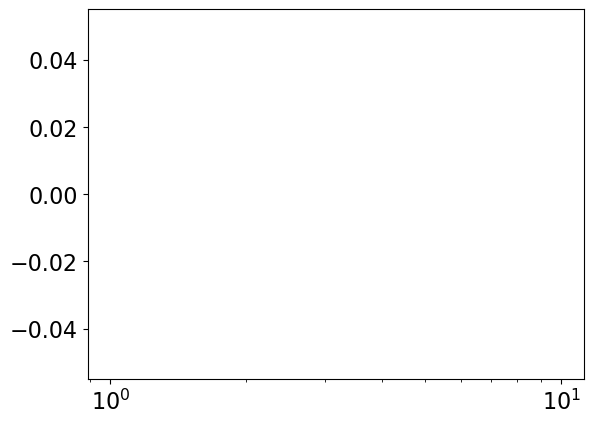

In [29]:
plt.figure()
plt.plot(g220[1:])
plt.plot(g225[1:])
plt.plot(g230[1:])
plt.semilogx()
plt.show()